In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx") #./../../data/Preise.xlsx   - Pfad für Sandbox
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "A",
                         "Region B": "B",
                         "Region C": "C",
                         "Region D": "D"})
)

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

In [5]:
def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [6]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [7]:
dataframes_online = [
    df_regAo,
    df_regBo,
    df_regCo,
    df_regDo
]

dataframes_a = [
    df_regAo,
    df_regAp,
    df_regAs
]

dataframes_b = [
    df_regBo,
    df_regBp,
    df_regBs
]

dataframes_c = [
    df_regCo,
    df_regCp,
    df_regCs
]

dataframes_d = [
    df_regDo,
    df_regDp,
    df_regDs
]

df_a = pd.concat(dataframes_a, ignore_index=True)
df_b = pd.concat(dataframes_b, ignore_index=True)
df_c = pd.concat(dataframes_c, ignore_index=True)
df_d = pd.concat(dataframes_d, ignore_index=True)

df_online = pd.concat(dataframes_online, ignore_index=True)
df_online

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Mini,1.0,3,0,1,0,NaN,136.06,NaN,...,44,136.06,408.18,550,1650,413.94,1241.82,6.1,D,online
84995,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.06,NaN,...,44,136.06,136.06,550,550,413.94,413.94,8.0,D,online
84996,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,136.06,NaN,...,44,136.06,272.12,550,1100,413.94,827.88,7.5,D,online
84997,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.02,NaN,...,44,136.02,136.02,550,550,413.98,413.98,6.8,D,online


<Axes: xlabel='date'>

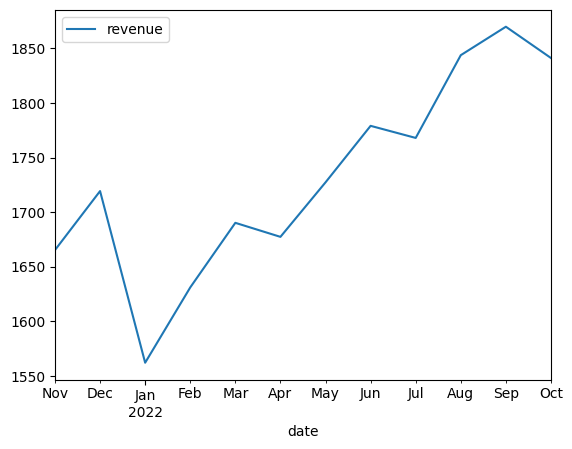

In [36]:
rev_per_week_all = df_reg_main.groupby(pd.Grouper(key="date", freq="1M")).agg({"revenue": "mean"}) # Umsatz pro Monat -> Klarer Umsatzrückgang

rev_per_week_all.plot()

<Axes: xlabel='date'>

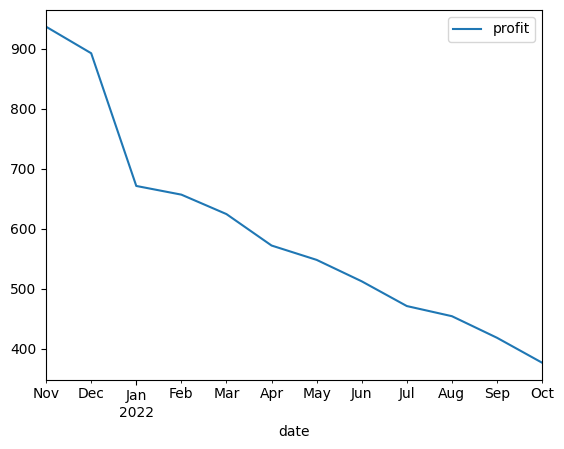

In [35]:
profit_per_week_all = df_reg_main.groupby(pd.Grouper(key="date", freq="1M")).agg({"profit": "mean"}) # Gewinn pro Monat -> Klarer Gewinnrückgang

profit_per_week_all.plot()

In [9]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In der Übersicht der Downtime kann man erkennen, dass die Downtime in A und B erheblich steigt, während diese in C und D stagniert. Nun steht die Hypothese im Raum, dass aufgrund dieses Umstandes das Kaufverhalten der Kunden im Online Umfeld verändert wurde.

<Axes: xlabel='date'>

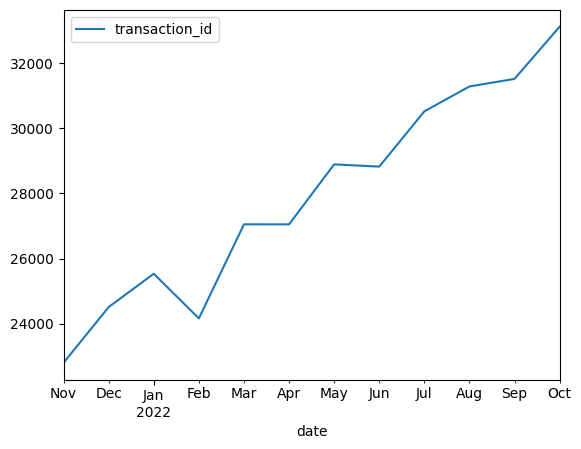

In [38]:
trans_per_week_all = df_reg_main.groupby(pd.Grouper(key="date", freq="1M")).agg({"transaction_id": "count"})

trans_per_week_all.plot()

<Axes: xlabel='date'>

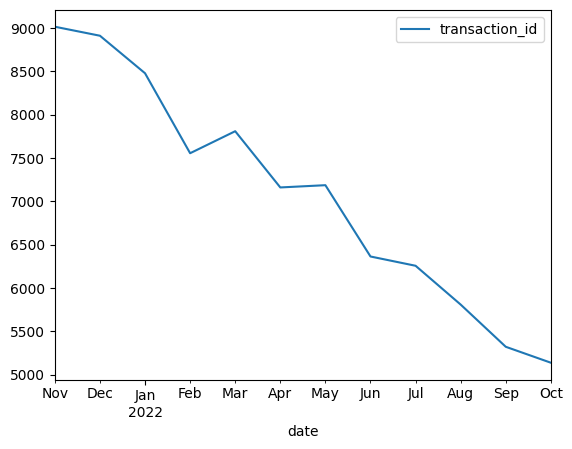

In [40]:
trans_per_month_online = df_online.groupby(pd.Grouper(key="date", freq="1M")).agg({"transaction_id": "count"})

trans_per_month_online.plot()

<Axes: xlabel='date', ylabel='profit'>

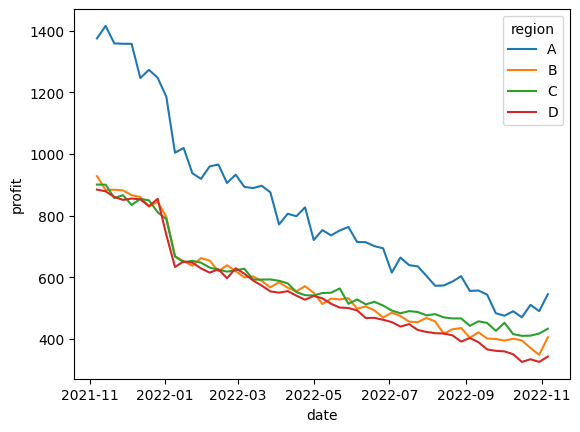

In [11]:
profit_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"profit": "mean"})
sns.lineplot(data=profit_per_week_vis, x="date", y="profit", hue="region")

<Axes: xlabel='date', ylabel='revenue'>

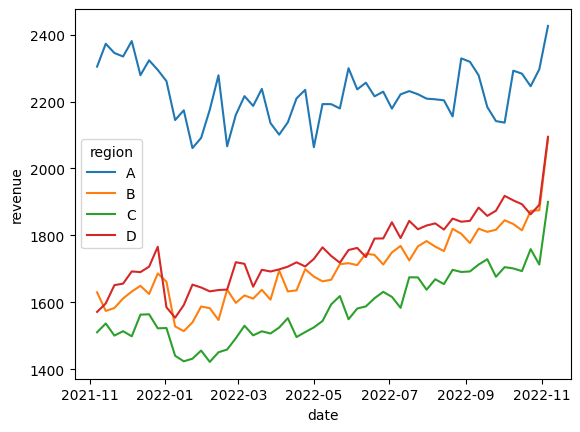

In [12]:
rev_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"revenue": "mean"})
sns.lineplot(data=rev_per_week_vis, x="date", y="revenue", hue="region")

transaction_id
region date                      
A      2021-11-07             547
       2021-11-14             520
       2021-11-21             556
       2021-11-28             528
       2021-12-05             525
...                           ...
D      2022-10-09            2682
       2022-10-16            2648
       2022-10-23            2756
       2022-10-30            2734
       2022-11-06             388

[212 rows x 1 columns]

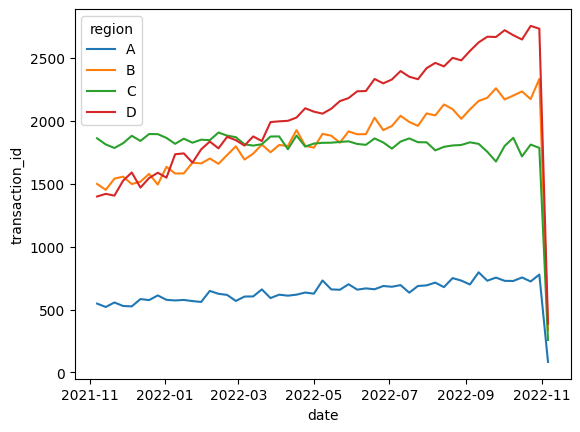

In [13]:
trans_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "count"})
sns.lineplot(data=trans_per_week_vis, x="date", y="transaction_id", hue="region")
trans_per_week_vis

<Axes: xlabel='date', ylabel='transaction_id'>

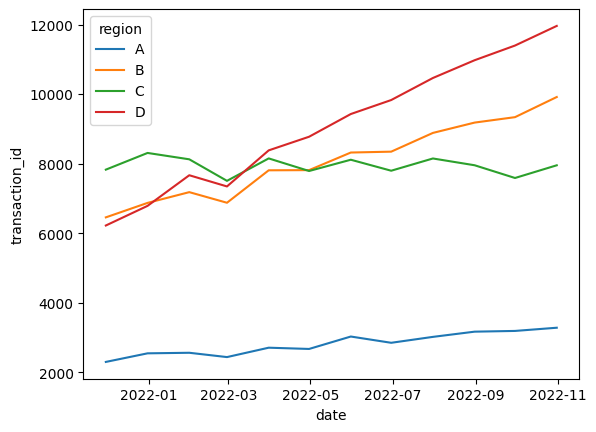

In [14]:
trans_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})
sns.lineplot(data=trans_per_week_vis, x="date", y="transaction_id", hue="region")

In [15]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


<Axes: xlabel='date', ylabel='revenue'>

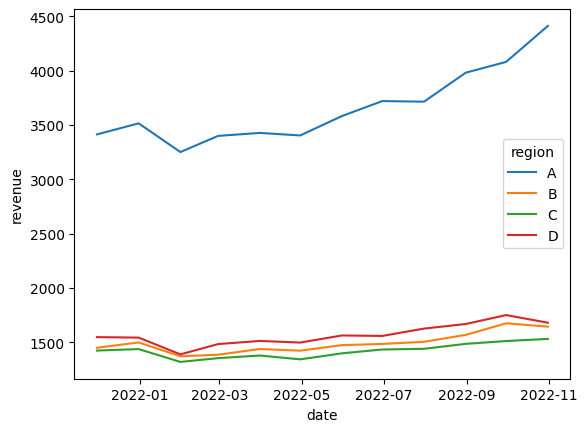

In [41]:
rev_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"revenue": "mean"})
sns.lineplot(data=rev_per_week_online, x="date", y="revenue", hue="region")

<Axes: xlabel='date', ylabel='profit'>

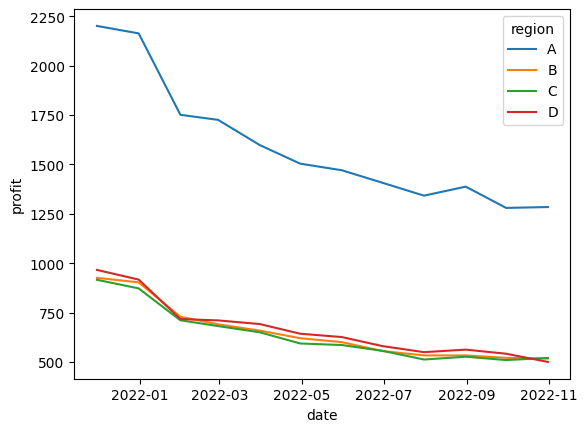

In [42]:
profit_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"profit": "mean"})
sns.lineplot(data=profit_per_week_online, x="date", y="profit", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

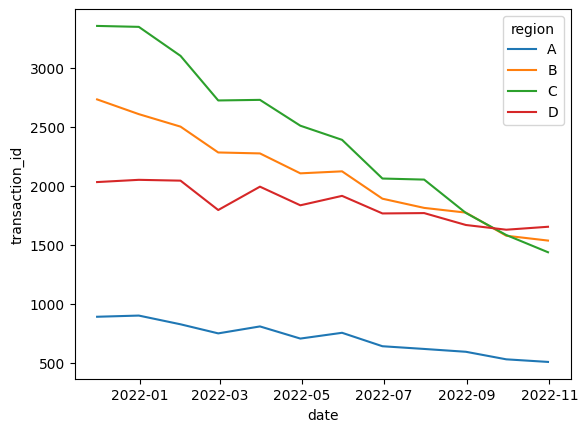

In [18]:
trans_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})
sns.lineplot(data=trans_per_week_online, x="date", y="transaction_id", hue="region")

In [19]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


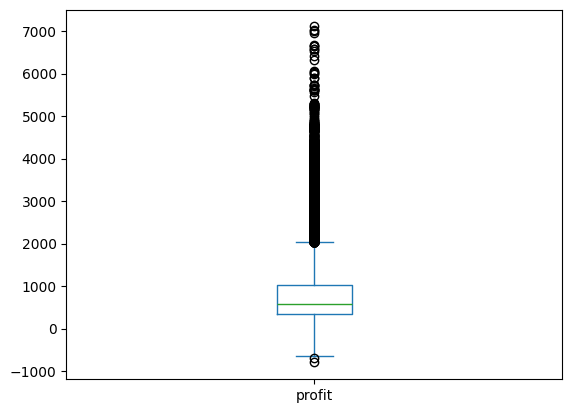

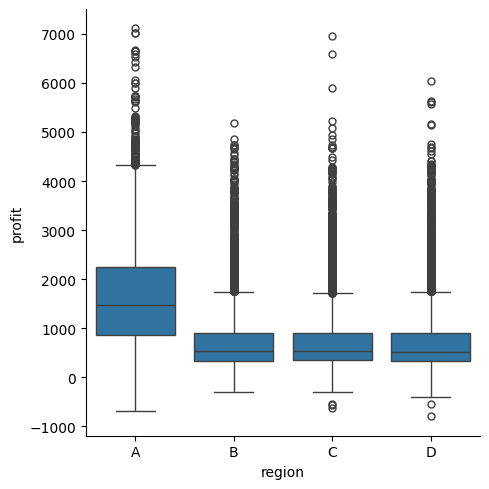

In [45]:
df_online.plot(x="region", y="profit", kind="box")

sns.catplot(data=df_online, x="region", y="profit", kind="box")

In [21]:
df_online.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,year,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating
count,84999,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,47867.000000,22121.000000,15011.000000,84999.000000,84999.000000,84999.000000,84999.0,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000
mean,2022-04-12 13:10:23.993223424,0.980430,2.822527,0.563148,0.260250,0.176602,261.276245,173.622811,797.917411,142358.742115,2021.789103,6.416252,26.109801,333.236373,920.658670,610.859328,1690.300133,277.622955,769.641463,6.701702
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.020000,530.790000,1.000000,2021.000000,1.000000,1.0,136.020000,136.020000,499.000000,499.000000,-79.600000,-796.000000,1.600000
25%,2022-01-12 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,200.390000,156.470000,753.910000,58357.500000,2022.000000,3.000000,12.0,182.810000,336.455000,499.000000,998.000000,197.265000,354.160000,5.300000
50%,2022-04-03 00:00:00,1.000000,2.000000,1.000000,0.000000,0.000000,248.700000,174.410000,804.560000,129493.000000,2022.000000,6.000000,25.0,233.770000,630.870000,529.000000,1497.000000,276.810000,590.560000,6.700000
75%,2022-07-07 00:00:00,1.000000,3.000000,1.000000,1.000000,0.000000,311.840000,191.250000,847.710000,218900.500000,2022.000000,10.000000,41.0,355.300000,1166.605000,550.000000,2040.000000,364.860000,1025.445000,8.000000
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,578.600000,216.620000,894.980000,339990.000000,2022.000000,12.000000,52.0,894.980000,9557.520000,999.000000,12987.000000,484.000000,7110.600000,10.000000
std,NaN,0.039674,1.998163,0.495999,0.438774,0.381334,74.685524,20.176643,61.529747,95865.662855,0.407948,3.646071,15.873983,227.147611,914.666875,183.681424,1264.109259,101.763708,641.191241,1.761070


In [22]:
df_online["downtime"] = ""

In [23]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In [24]:
df_dt.loc[:, df_online["region"]]

,A,A,A,A,A,A,A,A,A,A,...,D,D,D,D,D,D,D,D,D,D
0,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [25]:
df_online

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace,downtime
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online,
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online,
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online,
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online,
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Mini,1.0,3,0,1,0,NaN,136.06,NaN,...,136.06,408.18,550,1650,413.94,1241.82,6.1,D,online,
84995,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.06,NaN,...,136.06,136.06,550,550,413.94,413.94,8.0,D,online,
84996,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,136.06,NaN,...,136.06,272.12,550,1100,413.94,827.88,7.5,D,online,
84997,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.02,NaN,...,136.02,136.02,550,550,413.98,413.98,6.8,D,online,


In [26]:
df_online_dt = pd.merge(df_online, df_dt, on='year', how='left')
for col in ['A', 'B', 'C', 'D']:
    df_online_dt.loc[df_online_dt['region'] == col, 'downtime'] = df_online_dt[col]

df_online_dt = df_online_dt.drop(["A", "B", "C", "D"], axis=1)

df_online_dt

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace,downtime
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online,0.1
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online,0.1
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online,0.1
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online,0.1
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Mini,1.0,3,0,1,0,NaN,136.06,NaN,...,136.06,408.18,550,1650,413.94,1241.82,6.1,D,online,0.01
84995,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.06,NaN,...,136.06,136.06,550,550,413.94,413.94,8.0,D,online,0.01
84996,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,136.06,NaN,...,136.06,272.12,550,1100,413.94,827.88,7.5,D,online,0.01
84997,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.02,NaN,...,136.02,136.02,550,550,413.98,413.98,6.8,D,online,0.01


In [49]:
df_online_dt_week = df_online_dt.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "count", "profit": "mean", "revenue": "mean", "customer_rating": "mean", "downtime": "median"})
df_online_dt_week

transaction_id       profit      revenue  customer_rating  \
region date                                                                    
A      2021-11-07             217  2185.394977  3352.889401         7.294009   
       2021-11-14             198  2302.977778  3561.363636         7.242424   
       2021-11-21             210  2179.715048  3388.538095         7.276190   
       2021-11-28             207  2173.355700  3401.937198         7.023671   
       2021-12-05             211  2115.551611  3363.985782         6.915640   
...                           ...          ...          ...              ...   
D      2022-10-09             386   520.686166  1699.261658         7.488083   
       2022-10-16             337   527.181276  1673.540059         7.474184   
       2022-10-23             388   501.955644  1750.840206         7.570619   
       2022-10-30             369   486.406965  1693.075881         7.758808   
       2022-11-06              53   491.038491  1903.962264         7.739623   

                  downtime  
region date                 
A      2021-11-07      0.1  
       2021-11-14      0.1  
       2021-11-21      0.1  
       2021-11-28      0.1  
       2021-12-05      0.1  
...                    ...  
D      2022-10-09     0.01  
       2022-10-16     0.01  
       2022-10-23     0.01  
       2022-10-30     0.01  
       2022-11-06     0.01  

[212 rows x 5 columns]

<Axes: xlabel='date', ylabel='customer_rating'>

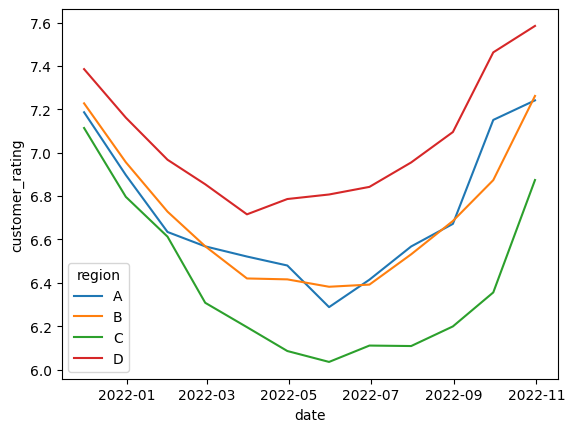

In [47]:
sns.lineplot(data=df_online_dt_week, x="date", y="customer_rating", hue="region")

In [53]:
model_online = smf.ols("profit ~ downtime + customer_rating", data=df_online_dt_week.loc[("A")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     81.23
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.96e-16
Time:                        10:36:58   Log-Likelihood:                -340.22
No. Observations:                  53   AIC:                             686.4
Df Residuals:                      50   BIC:                             692.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3398.4693    437.464      7.769      0.000    2519.797    4277.142
downtime[T.0.15]  -756.1937     59.946    -12.615      0.000    -876.598    -635.789
customer_rating   -175.8711     61.825     -2.845      0.006    -300.051     -51.691
==============================================================================
Omnibus:                        3.590   Durbin-Watson:                   0.704
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                3.125
Skew:                           0.595   Prob(JB):                        0.210
Kurtosis:                       2.974   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model_online = smf.ols("transaction_id ~ downtime", data=df_online_dt_week.loc[("B")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     23.66
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.15e-05
Time:                        09:40:16   Log-Likelihood:                -313.41
No. Observations:                  53   AIC:                             630.8
Df Residuals:                      51   BIC:                             634.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          610.8889     30.420     20.082      0.000     549.819     671.959
downtime[T.0.15]  -162.3889     33.386     -4.864      0.000    -229.414     -95.363
==============================================================================
Omnibus:                       27.356   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.026
Skew:                          -1.392   Prob(JB):                     3.77e-16
Kurtosis:                       7.940   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model_online = smf.ols("transaction_id ~ downtime", data=df_online_dt_week.loc[("C")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     30.28
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.22e-06
Time:                        09:40:16   Log-Likelihood:                -332.87
No. Observations:                  53   AIC:                             669.7
Df Residuals:                      51   BIC:                             673.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          503.5682     19.860     25.356      0.000     463.697     543.439
downtime[T.0.05]   265.2096     48.195      5.503      0.000     168.455     361.964
==============================================================================
Omnibus:                        7.420   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.030
Skew:                          -0.628   Prob(JB):                       0.0297
Kurtosis:                       4.267   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
model_online = smf.ols("transaction_id ~ downtime", data=df_online_dt_week.loc[("D")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     7.138
Date:                Wed, 06 Dec 2023   Prob (F-statistic):             0.0101
Time:                        09:40:16   Log-Likelihood:                -293.39
No. Observations:                  53   AIC:                             590.8
Df Residuals:                      51   BIC:                             594.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          468.8889     20.850     22.488      0.000     427.030     510.748
downtime[T.0.01]   -61.1389     22.884     -2.672      0.010    -107.080     -15.198
==============================================================================
Omnibus:                       71.775   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.320
Skew:                          -3.518   Prob(JB):                    2.52e-187
Kurtosis:                      21.429   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""